# XGBoost Use Case: HIGGS - Classification

## 1. Environment Setup

In [13]:
# --- Installation ---
import os
import sys

# Check if environment initialized
try:
    import xgboost
    import shap
    ENV_INITIALIZED = True
except ImportError:
    ENV_INITIALIZED = False

if not ENV_INITIALIZED:
    print("Installing dependencies...")
    # Pin versions for reproducibility

    # PyTorch with specific CUDA 12.4 support
    !pip install --quiet torch==2.6.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

    # Core compute and ML libraries
    !pip install --quiet \
        numpy==2.0.2 \
        pandas==2.2.2 \
        pyarrow==16.1.0 \
        scikit-learn==1.6.1 \
        xgboost==2.1.4

    # Plotting libraries
    !pip install --quiet \
        matplotlib==3.9.0 \
        seaborn==0.13.2

    # Model explainability, data repository, and system utilities
    !pip install --quiet \
        shap==0.46.0 \
        requests==2.32.3 \
        py-cpuinfo==9.0.0 \
        psutil==6.0.0

    print("Dependencies installed successfully. Please restart the runtime.")
    # Programmatically exit to restart the runtime.
    os._exit(0)
else:
    print("Dependencies already installed.")


Dependencies already installed.


In [14]:
def get_system_info(bench="flk"):
    """Gathers and returns key hardware and software information as a dictionary."""
    info = {}
    try:
        # Environment
        info["python_version"] = platform.python_version()
        info["python_executable"] = sys.executable

        # Software
        info["torch_version"] = torch.__version__
        info["numpy_version"] = np.__version__
        info["pandas_version"] = pd.__version__
        info["sklearn_version"] = sklearn.__version__

        # Benchmark-specific libraries
        if bench == "flk":
            info["falkon_version"] = falkon.__version__
            info["pykeops_version"] = pykeops.__version__
        elif bench == "xgb":
            info["xgboost_version"] = xgb.__version__
            info["shap_version"] = shap.__version__

        # Hardware
        info["os"] = f"{platform.system()} {platform.release()}"
        info["cpu_model"] = cpuinfo.get_cpu_info().get("brand_raw", "N/A")
        info["ram_total_gb"] = psutil.virtual_memory().total / (1024**3)

        # GPU Hardware
        if torch.cuda.is_available():
            info["gpu_model"] = torch.cuda.get_device_name(0)
            info["gpu_vram_gb"] = torch.cuda.get_device_properties(0).total_memory / (
                1024**3
            )
            info["cuda_version"] = torch.version.cuda
        else:
            info["gpu_model"] = "N/A"
            info["gpu_vram_gb"] = 0
            info["cuda_version"] = "N/A"
    except Exception as e:
        print(f"Could not retrieve all system info: {e}")
    return info


In [15]:
# --- Library Imports ---

# Core libraries
import xgboost as xgb
import torch
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.ensemble import GradientBoostingClassifier

# Visualization and Utilities
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

import time
import platform
import psutil
import cpuinfo
import requests
import gc
from IPython.display import display, Markdown

print("Libraries imported successfully.")
get_system_info("xgb")


Libraries imported successfully.


{'python_version': '3.11.13',
 'python_executable': '/usr/bin/python3',
 'torch_version': '2.6.0+cu124',
 'numpy_version': '2.0.2',
 'pandas_version': '2.2.2',
 'sklearn_version': '1.6.1',
 'xgboost_version': '3.0.2',
 'shap_version': '0.48.0',
 'os': 'Linux 6.1.123+',
 'cpu_model': 'Intel(R) Xeon(R) CPU @ 2.20GHz',
 'ram_total_gb': 83.4760627746582,
 'gpu_model': 'NVIDIA A100-SXM4-40GB',
 'gpu_vram_gb': 39.55743408203125,
 'cuda_version': '12.4'}

## 2. Data Preparation

In [16]:
def download_higgs(data_dir="."):
    """Downloads the HIGGS dataset if it is not already present."""
    os.makedirs(data_dir, exist_ok=True)
    higgs_filename = os.path.join(data_dir, "HIGGS.csv.gz")

    if os.path.exists(higgs_filename):
        print(f"HIGGS data file found at '{higgs_filename}'. Skipping download.")
        return higgs_filename

    print(f"HIGGS data not found in '{data_dir}'. Starting download...")
    higgs_url = (
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz"
    )

    try:
        response = requests.get(higgs_url, stream=True)
        response.raise_for_status()
        with open(higgs_filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Download complete. Data saved to '{higgs_filename}'")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the HIGGS dataset: {e}")
        return None

    return higgs_filename


In [17]:
def load_higgs(data_path, n_samples_train):
    """Loads and prepares the HIGGS dataset for a specific sample size."""
    if not data_path or not os.path.exists(data_path):
        raise FileNotFoundError(
            f"Data file not found at {data_path}. Please run download_higgs first."
        )

    # --- Caching Logic: Define cache path and check for existence ---
    base_name, _ = os.path.splitext(os.path.basename(data_path))
    cache_dir = os.path.dirname(data_path)
    cache_path = os.path.join(cache_dir, f"{base_name}_N{n_samples_train}.pkl")

    if os.path.exists(cache_path):
        print(f"Cache found! Loading pre-processed data from '{cache_path}'...")
        data_dict = joblib.load(cache_path)
        print(
            f"Data loaded from cache. Train shape: {data_dict['X_train'].shape}, Test shape: {data_dict['X_test'].shape}"
        )
        return (
            data_dict["X_train"],
            data_dict["y_train"],
            data_dict["X_test"],
            data_dict["y_test"],
        )

    # --- If cache not found, run the full processing pipeline ---
    print(f"Cache not found for N={n_samples_train}. Starting full data processing...")

    # Load full dataset
    print(f"Loading full dataset from '{data_path}'...")
    try:
        df_higgs = pd.read_csv(data_path, header=None, compression="gzip")
        X_df = df_higgs.iloc[:, 1:]
        y_series = df_higgs.iloc[:, 0].astype(int)
        X_df.columns = [f"feature_{i}" for i in range(X_df.shape[1])]
        del df_higgs
        gc.collect()
    except Exception as e:
        print(f"Error loading or processing CSV file: {e}")
        return None, None, None, None

    print(f"Full dataset loaded. Shape: {X_df.shape}")

    # Split full dataset to maintain a consistent test set
    print("Splitting data into a training pool and a final test set...")
    X_train_pool, X_test, y_train_pool, y_test = train_test_split(
        X_df,
        y_series,
        test_size=0.2,  # Reserve 20% for testing
        random_state=GLOBAL_PARAMS["RANDOM_STATE"],
        stratify=y_series,
    )
    del X_df, y_series
    gc.collect()

    # Subsample training data from the pool
    print(f"Subsampling training pool to {n_samples_train} instances...")
    X_train, _, y_train, _ = train_test_split(
        X_train_pool,
        y_train_pool,
        train_size=n_samples_train,
        random_state=GLOBAL_PARAMS["RANDOM_STATE"],
        stratify=y_train_pool,
    )
    del X_train_pool, y_train_pool
    gc.collect()

    # Scale features
    print("Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    del X_train, X_test
    gc.collect()

    # --- Caching Logic: Save the newly created data to disk ---
    print(f"\nSaving processed data to cache at '{cache_path}'...")
    data_to_save = {
        "X_train": X_train_scaled,
        "y_train": y_train.values,
        "X_test": X_test_scaled,
        "y_test": y_test.values,
    }
    joblib.dump(data_to_save, cache_path)
    print("Save complete.")

    print(
        f"\nData prepared. Train shape: {X_train_scaled.shape}, Test shape: {X_test_scaled.shape}"
    )
    return X_train_scaled, y_train.values, X_test_scaled, y_test.values


In [18]:
# Download data
CONSOLIDATED_DATA_PATH = download_higgs("./data")


HIGGS data file found at './data/HIGGS.csv.gz'. Skipping download.


## 3. Methodology & Helper Functions

In [19]:
def timed_execution(func, *args, **kwargs):
    """Measures execution time of a function, averaging over N_RUNS repetitions."""
    times = []
    result = None
    print(
        f"Benchmarking '{func.__name__}' for {GLOBAL_PARAMS['N_RUNS']} repetitions..."
    )

    # Run N_RUNS times for timing
    for i in range(GLOBAL_PARAMS["N_RUNS"]):
        # Start time
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        start_time = time.time()

        # Function call
        result = func(*args, **kwargs)

        # Stop time
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        end_time = time.time()

        times.append(end_time - start_time)
        print(
            f"  Repetition {i+1}/{GLOBAL_PARAMS['N_RUNS']} complete in {times[-1]:.4f}s"
        )

    # Report average time
    avg_time = np.mean(times)
    print(f"Average execution time: {avg_time:.4f}s")

    # Return last model result, average time, and individual timings
    return result, avg_time, times


In [20]:
def evaluate_classification(y_true, y_pred_binary, y_pred_proba):
    """Calculates classification metrics from predictions and returns them as a dictionary."""
    # Ensure inputs are NumPy arrays
    y_true_np = y_true.cpu().numpy() if isinstance(y_true, torch.Tensor) else y_true

    # Calculate metrics
    accuracy = accuracy_score(y_true_np, y_pred_binary)
    f1 = f1_score(y_true_np, y_pred_binary)
    auc = roc_auc_score(y_true_np, y_pred_proba)

    # Report results
    print("Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  AUC: {auc:.4f}")

    return {"accuracy": accuracy, "f1_score": f1, "auc": auc}


## 4. Experiment Configuration

In [21]:
# --- A. Experiment Naming ---
# Name for the output CSV file.
EXPERIMENT_NAME = "benchmark_xgboost_higgs"

# --- B. Benchmark Selection ---
# Global flags to enable/disable entire benchmark categories.
RUN_CONTROLS = {
    "RUN_GPU_HIST": True,
    "RUN_CPU_HIST": True,
    "RUN_CPU_APPROX": True,
    "RUN_CPU_EXACT": True,
    "RUN_SKLEARN_GBC": True,
}

# --- C. Scalability Run Definitions ---
# Define the list of sample sizes (N) to benchmark against.
N_SAMPLES_LIST = [
    10_000,
    50_000,
    100_000,
    250_000,
    500_000,
    1_000_000,
    2_000_000,
    5_000_000,
    8_000_000,
]

# Define configurations for the scalability study.
EXPERIMENT_CONFIGS = [
    {
        "n_samples": n,
        "gpu_hist": True,
        "cpu_hist": True if n <= 5_000_000 else False,
        "cpu_approx": True if n <= 500_000 else False,
        "cpu_exact": True if n <= 500_000 else False,
        "sklearn_gbc": True if n <= 100_000 else False,
    }
    for n in N_SAMPLES_LIST
]

# --- D. Global Model and Run Parameters ---
GLOBAL_PARAMS = {
    "N_RUNS": 5,
    "RANDOM_STATE": 6,
    "MAX_TEST_SAMPLES": 250_000,
    "DATA_DIR": "./data",
}

# Base hyperparameters for the XGBoost model
HYPERPARAMS = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.05,
    "max_depth": 8,
    "n_estimators": 500,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "seed": GLOBAL_PARAMS["RANDOM_STATE"],
    # gamma, lambda, and alpha will use their robust defaults (0, 1, and 0)
}

# Seed for reproducibility
np.random.seed(GLOBAL_PARAMS["RANDOM_STATE"])
os.makedirs(GLOBAL_PARAMS["DATA_DIR"], exist_ok=True)


In [22]:
def run_xgboost_bin(data_path, N, base_params, tree_method, device):
    """Runs a full XGBoost benchmark and returns a dictionary of results."""
    model_label = f"XGBoost ({device}, {tree_method})"
    print(f"\n--- Starting Benchmark for: {model_label} ---")

    # Loading
    X_train, y_train, X_test, y_test = load_higgs(data_path, N)

    # Configure XGBoost parameters
    params = base_params.copy()
    params["tree_method"] = tree_method
    if device == "cuda":
        params["device"] = "cuda"
    else:
        params["n_jobs"] = -1

    # Training
    def train_xgb():
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train, verbose=False)
        return model

    model, train_time, train_times = timed_execution(train_xgb)
    print(f"  Training complete: {train_time:.4f}s")
    del X_train, y_train
    gc.collect()

    # Prediction
    def predict_xgb():
        preds = model.predict_proba(X_test)[:, 1]
        return preds

    pred_proba, pred_time, pred_times = timed_execution(predict_xgb)

    # Evaluation
    pred_binary = (pred_proba > 0.5).astype(int)
    metrics = evaluate_classification(y_test, pred_binary, pred_proba)

    # Compile results
    results = {
        "model": model,
        "train_time": train_time,
        "train_times": train_times,
        "pred_time": pred_time,
        "pred_times": pred_times,
        "metrics": metrics,
        "model_label": model_label,
        "status": "Success",
    }

    print(f"--- Benchmark for {model_label} complete. ---")
    return results


In [23]:
def run_sklearn_gbc(data_path, N, base_params):
    """Runs a Scikit-learn GradientBoostingClassifier benchmark as a CPU baseline."""
    model_label = "Scikit-learn GBC (CPU)"

    try:
        print(f"\n--- Starting Benchmark for: {model_label} ---")

        # Loading
        X_train, y_train, X_test, y_test = load_higgs(data_path, N)

        # Configuration
        skl_params = {
            "n_estimators": base_params["n_estimators"],
            "learning_rate": base_params["eta"],
            "max_depth": base_params["max_depth"],
            "subsample": base_params["subsample"],
            "max_features": base_params["colsample_bytree"],
            "random_state": base_params["seed"],
        }

        # Training
        def train_skl_gbc():
            model = GradientBoostingClassifier(**skl_params)
            model.fit(X_train, y_train)
            return model

        model, train_time, train_times = timed_execution(train_skl_gbc)

        print(f"  Training complete: {train_time:.4f}s")
        del X_train, y_train
        gc.collect()

        # Prediction
        def predict_skl_gbc():
            preds = model.predict_proba(X_test)[:, 1]
            return preds

        pred_proba, pred_time, pred_times = timed_execution(predict_skl_gbc)

        # Evaluation
        pred_binary = (pred_proba > 0.5).astype(int)
        metrics = evaluate_classification(y_test, pred_binary, pred_proba)

        # Results
        results = {
            "model": model,
            "train_time": train_time,
            "train_times": train_times,
            "pred_time": pred_time,
            "pred_times": pred_times,
            "metrics": metrics,
            "model_label": model_label,
            "status": "Success",
        }

        print(f"--- Benchmark for {model_label} complete. ---")
        return results

    except MemoryError:
        print(f"!!! {model_label} failed for N={N} due to MemoryError. !!!")
        return {
            "model": None,
            "train_time": -1,
            "train_times": [],
            "pred_time": -1,
            "pred_times": [],
            "metrics": {},
            "model_label": model_label,
            "status": "MemoryError",
        }
    except Exception as e:
        print(f"!!! {model_label} failed for N={N} due to an exception: {e} !!!")
        return {
            "model": None,
            "train_time": -1,
            "train_times": [],
            "pred_time": -1,
            "pred_times": [],
            "metrics": {},
            "model_label": model_label,
            "status": "Error",
        }


## 5. Execution Engine

In [24]:
all_run_results = []
data_path = download_higgs(GLOBAL_PARAMS["DATA_DIR"])
system_info = get_system_info("xgb")

print("Starting experiment runs...")
print("---" * 20)

for i, config in enumerate(EXPERIMENT_CONFIGS):
    n_samples = config["n_samples"]

    print(f"\n>>> RUN {i+1}/{len(EXPERIMENT_CONFIGS)}: N={n_samples} <<<\n")

    base_results = {**system_info, **config}

    # --- Run Benchmarks based on flags ---
    if RUN_CONTROLS["RUN_GPU_HIST"] and config["gpu_hist"]:
        results = run_xgboost_bin(data_path, n_samples, HYPERPARAMS, "hist", "cuda")
        all_run_results.append({**base_results, **results})

    if RUN_CONTROLS["RUN_CPU_HIST"] and config["cpu_hist"]:
        results = run_xgboost_bin(data_path, n_samples, HYPERPARAMS, "hist", "cpu")
        all_run_results.append({**base_results, **results})

    if RUN_CONTROLS["RUN_CPU_APPROX"] and config["cpu_approx"]:
        results = run_xgboost_bin(data_path, n_samples, HYPERPARAMS, "approx", "cpu")
        all_run_results.append({**base_results, **results})

    if RUN_CONTROLS["RUN_CPU_EXACT"] and config["cpu_exact"]:
        results = run_xgboost_bin(data_path, n_samples, HYPERPARAMS, "exact", "cpu")
        all_run_results.append({**base_results, **results})

    if RUN_CONTROLS["RUN_SKLEARN_GBC"] and config["sklearn_gbc"]:
        results = run_sklearn_gbc(data_path, n_samples, HYPERPARAMS)
        all_run_results.append({**base_results, **results})

    gc.collect()
    print(f"\n>>> RUN {i+1}/{len(EXPERIMENT_CONFIGS)} COMPLETE <<<\n\n")


print("---" * 20)
print("All experiment runs complete.")


HIGGS data file found at './data/HIGGS.csv.gz'. Skipping download.
Starting experiment runs...
------------------------------------------------------------

>>> RUN 1/9: N=10000 <<<


--- Starting Benchmark for: XGBoost (cuda, hist) ---
Cache found! Loading pre-processed data from './data/HIGGS.csv_N10000.pkl'...
Data loaded from cache. Train shape: (10000, 28), Test shape: (2200000, 28)
Benchmarking 'train_xgb' for 5 repetitions...
  Repetition 1/5 complete in 1.4943s
  Repetition 2/5 complete in 1.4494s
  Repetition 3/5 complete in 1.4662s
  Repetition 4/5 complete in 1.6352s
  Repetition 5/5 complete in 1.4440s
Average execution time: 1.4978s
  Training complete: 1.4978s
Benchmarking 'predict_xgb' for 5 repetitions...
  Repetition 1/5 complete in 0.6471s
  Repetition 2/5 complete in 0.6553s
  Repetition 3/5 complete in 0.6396s
  Repetition 4/5 complete in 0.6364s
  Repetition 5/5 complete in 0.6420s
Average execution time: 0.6441s
Metrics:
  Accuracy: 0.7079
  F1 Score: 0.7276
  AUC

## 6. Results Summary & Export

--- Final Results Summary ---


,model_label,n_samples,status,train_time,train_times,pred_time,pred_times,auc,f1_score,accuracy,cpu_model,gpu_model,ram_total_gb,python_version,xgboost_version
0,"XGBoost (cuda, hist)",10000,Success,1.497847,"[1.4943158626556396, 1.4494397640228271, 1.466...",0.644090,"[0.6471462249755859, 0.6552767753601074, 0.639...",0.781159,0.727581,0.707891,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,3.11.13,3.0.2
1,"XGBoost (cpu, hist)",10000,Success,1.961132,"[1.6318278312683105, 1.6618289947509766, 3.208...",5.115213,"[5.025295257568359, 5.231345176696777, 5.02477...",0.780375,0.726879,0.707289,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,3.11.13,3.0.2
2,"XGBoost (cpu, approx)",10000,Success,4.887069,"[4.261716365814209, 5.801511287689209, 4.34337...",5.132995,"[4.995308876037598, 5.366637229919434, 5.03647...",0.780493,0.726865,0.707215,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,3.11.13,3.0.2
3,"XGBoost (cpu, exact)",10000,Success,5.130928,"[4.513114929199219, 6.018352031707764, 4.51560...",5.103545,"[5.008636236190796, 5.243441581726074, 4.99749...",0.780297,0.726621,0.706936,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,3.11.13,3.0.2
4,Scikit-learn GBC (CPU),10000,Success,67.296276,"[67.38096213340759, 67.28919863700867, 67.2938...",47.645995,"[47.6579110622406, 47.627299308776855, 47.6402...",0.780191,0.726532,0.707173,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,3.11.13,3.0.2
5,"XGBoost (cuda, hist)",50000,Success,1.882907,"[1.9195170402526855, 1.8633720874786377, 1.901...",0.646630,"[0.6633002758026123, 0.6485769748687744, 0.642...",0.805604,0.744264,0.726920,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,3.11.13,3.0.2
6,"XGBoost (cpu, hist)",50000,Success,3.336844,"[4.038351535797119, 3.004648447036743, 2.78550...",5.282844,"[5.154460430145264, 5.1736814975738525, 5.4753...",0.805433,0.744412,0.727032,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,3.11.13,3.0.2
7,"XGBoost (cpu, approx)",50000,Success,13.594075,"[13.685604333877563, 13.682878255844116, 13.53...",5.271690,"[5.299354314804077, 5.2811362743377686, 5.1473...",0.805742,0.744461,0.727103,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,3.11.13,3.0.2
8,"XGBoost (cpu, exact)",50000,Success,19.579696,"[20.12929606437683, 18.85811758041382, 20.0623...",5.192048,"[5.0932087898254395, 5.379883766174316, 5.0798...",0.805759,0.744724,0.727123,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,3.11.13,3.0.2
9,Scikit-learn GBC (CPU),50000,Success,321.421937,"[321.7776732444763, 321.0301704406738, 320.380...",45.011504,"[44.9761061668396, 44.98934769630432, 45.03044...",0.804870,0.743244,0.726146,Intel(R) Xeon(R) CPU @ 2.20GHz,NVIDIA A100-SXM4-40GB,83.476063,3.11.13,3.0.2



Results successfully saved to 'benchmark_xgboost_higgs.csv'

--- Visualization for Scalability (N) Benchmark ---


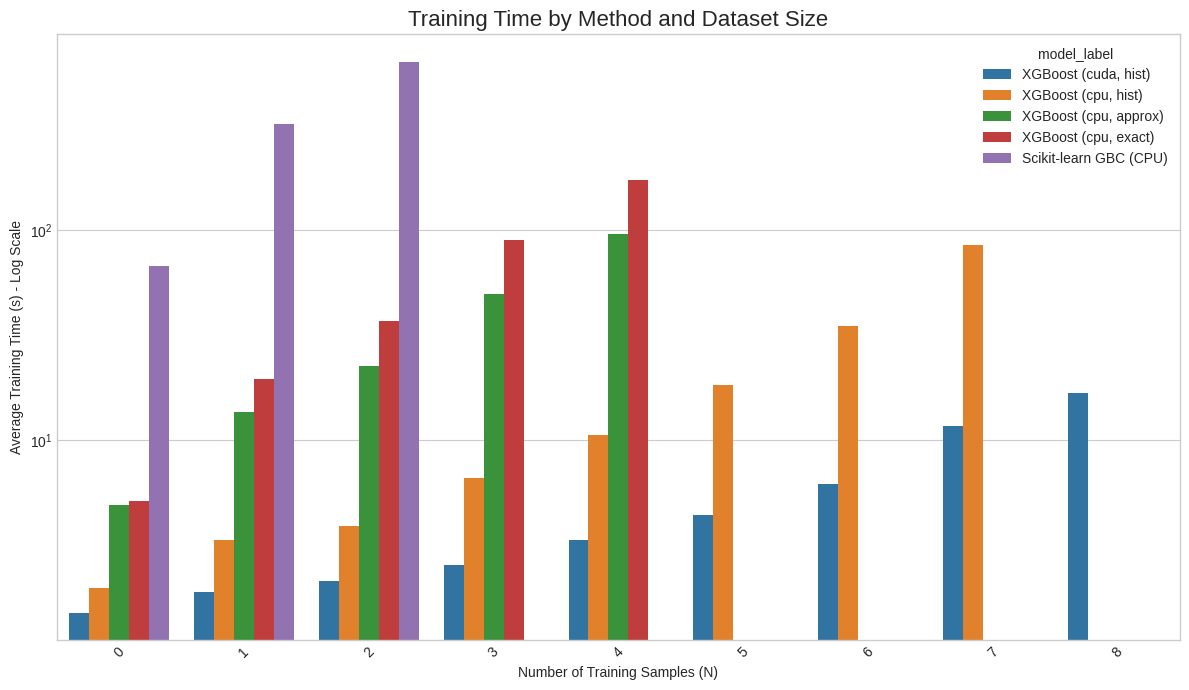

In [25]:
if all_run_results:
    # --- 1. Data Processing and Saving ---
    results_df = pd.DataFrame(all_run_results)

    if "metrics" in results_df.columns:
        metrics_df = results_df["metrics"].apply(pd.Series)
        results_df = pd.concat([results_df.drop("metrics", axis=1), metrics_df], axis=1)

    # Reorder columns for clarity
    col_order = [
        "model_label",
        "n_samples",
        "status",
        "train_time",
        "train_times",
        "pred_time",
        "pred_times",
        "auc",
        "f1_score",
        "accuracy",
        "cpu_model",
        "gpu_model",
        "ram_total_gb",
        "python_version",
        "xgboost_version",
    ]
    results_df = results_df[[c for c in col_order if c in results_df.columns]]

    # Display results
    print("--- Final Results Summary ---")
    display(results_df)

    # Save to CSV
    output_filename = f"{EXPERIMENT_NAME}.csv"
    results_df.to_csv(output_filename, index=False)
    print(f"\nResults successfully saved to '{output_filename}'")

    # --- 2. Visualization ---
    is_scalability_experiment = len(results_df["n_samples"].unique()) > 1

    if is_scalability_experiment:
        print("\n--- Visualization for Scalability (N) Benchmark ---")
        plt.style.use("seaborn-v0_8-whitegrid")
        fig, ax = plt.subplots(figsize=(12, 7))

        plot_df = results_df[results_df["status"] == "Success"].copy()

        sns.barplot(
            data=plot_df, x="n_samples", y="train_time", hue="model_label", ax=ax
        )
        ax.set_title("Training Time by Method and Dataset Size", fontsize=16)
        ax.set_ylabel("Average Training Time (s) - Log Scale")
        ax.set_xlabel("Number of Training Samples (N)")
        ax.set_yscale("log")

        ax.get_xaxis().set_major_formatter(
            plt.FuncFormatter(lambda x, p: format(int(x), ","))
        )
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

else:
    print("No results were generated.")


In [26]:
# Check if a GPU model label exists in the final DataFrame
if "XGBoost (cuda, hist)" in results_df["model_label"].unique():
    print("\n--- Starting Interpretation and Plotting ---")

    # Find the specific run for the largest GPU model from the original results list
    final_model_run = None
    max_n = 0
    for res in all_run_results:
        if (
            res.get("model_label") == "XGBoost (cuda, hist)"
            and res.get("n_samples", 0) > max_n
        ):
            max_n = res["n_samples"]
            final_model_run = res

    if final_model_run and final_model_run.get("model"):
        print(f"Found target model: XGBoost (cuda, hist) with N = {max_n:,}")
        model = final_model_run["model"]

        # 1. Reload the corresponding test data
        print("  Reloading test data...")
        _, _, X_test, y_test = load_higgs(data_path, n_samples_train=max_n)
        print(f"  Test data for N={max_n:,} loaded successfully.")

        # --- Plot Generation ---

        # 2. Generate and save the Confusion Matrix plot
        print("  Generating and saving Confusion Matrix plot...")
        from sklearn.metrics import confusion_matrix
        import seaborn as sns
        import matplotlib.pyplot as plt

        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Background", "Signal"],
            yticklabels=["Background", "Signal"],
        )
        plt.title("Confusion Matrix", fontsize=16)
        plt.ylabel("Actual Label")
        plt.xlabel("Predicted Label")
        plt.savefig(
            f"{EXPERIMENT_NAME}_interpretation_confusion_matrix.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.close()

        # 3. Generate and save the Feature Importance plot
        print("  Generating and saving Feature Importance plot...")
        feature_importances = model.get_booster().get_score(importance_type="gain")
        importance_df = (
            pd.DataFrame(list(feature_importances.items()), columns=["feature", "gain"])
            .sort_values("gain", ascending=False)
            .head(15)
        )

        plt.figure(figsize=(10, 8))
        sns.barplot(x="gain", y="feature", data=importance_df, palette="viridis")
        plt.title("Feature Importance (Gain)", fontsize=16)
        plt.xlabel("Gain")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.savefig(f"{EXPERIMENT_NAME}_interpretation_feature_importance.png", dpi=300)
        plt.close()

        # 4. Calculate, generate, and save SHAP plots
        print("  Calculating SHAP values (this may take a while)...")
        import shap

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        # SHAP Bar Plot
        print("  Generating and saving SHAP bar plot...")
        shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
        plt.title("SHAP Summary Plot (Mean Absolute Value)", fontsize=16)
        plt.savefig(
            f"{EXPERIMENT_NAME}_interpretation_shap_bar.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.close()

        # SHAP Dot Plot
        print("  Generating and saving SHAP dot plot...")
        shap.summary_plot(shap_values, X_test, show=False)
        plt.title("SHAP Summary Plot", fontsize=16)
        plt.savefig(
            f"{EXPERIMENT_NAME}_interpretation_shap_dot.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.close()

        print("\n--- All interpretation plots saved successfully! ---")

    else:
        print("Could not find the final model object to generate diagnostics.")

else:
    print(
        "\n--- Skipping Interpretation Block: No 'XGBoost (cuda, hist)' model found. ---"
    )



--- Starting Interpretation and Plotting ---
Found target model: XGBoost (cuda, hist) with N = 8,000,000
  Reloading test data...
Cache found! Loading pre-processed data from './data/HIGGS.csv_N8000000.pkl'...
Data loaded from cache. Train shape: (8000000, 28), Test shape: (2200000, 28)
  Test data for N=8,000,000 loaded successfully.
  Generating and saving Confusion Matrix plot...
  Generating and saving Feature Importance plot...


/tmp/ipython-input-26-3943345934.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="gain", y="feature", data=importance_df, palette="viridis")


  Calculating SHAP values (this may take a while)...
  Generating and saving SHAP bar plot...


/tmp/ipython-input-26-3943345934.py:82: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)


  Generating and saving SHAP dot plot...


/tmp/ipython-input-26-3943345934.py:93: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, show=False)



--- All interpretation plots saved successfully! ---
